In [1]:
import torch
import yaml 
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
import numpy as np

from model.PairVAE import PairVAE
from model.pl_PairVAE import PlPairVAE
from dataset.datasetPairH5 import PairHDF5Dataset


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Params

In [17]:
dossier = "/projects/pnria/julien/autofill/lightning_logs/version_71988/"
fichiers = [f for f in os.listdir(dossier) if os.path.isfile(os.path.join(dossier, f))]

print(fichiers)

['config_model.yaml', 'train_indices.npy', 'val_indices.npy', 'events.out.tfevents.1741962296.r9ng-1080-6.1848776.0', 'hparams.yaml']


In [18]:
path_checkpoint = "/projects/pnria/julien/autofill/lightning_logs/version_71988/checkpoints/epoch=99-step=122300.ckpt"
path_config = "/projects/pnria/julien/autofill/lightning_logs/version_71988/config_model.yaml"

In [19]:
array_valid = np.load("/projects/pnria/julien/autofill/lightning_logs/version_71988/val_indices.npy")
array_valid

array([31684, 25103, 24767, ..., 41106, 30053, 28280])

In [20]:
array_train = np.load("/projects/pnria/julien/autofill/lightning_logs/version_71988/train_indices.npy")
array_train

array([31101, 47785, 47519, ..., 26504, 37302, 47121])

In [21]:
with open(path_config, 'r') as file:
    config = yaml.safe_load(file)

In [44]:
config

{'dataset': {'hdf5_file': '/projects/pnria/caroline/pair_saxs_les_closest_of_concentration.h5',
  'pad_size': 80,
  'material': ['ag'],
  'conversion_dict_path': '/projects/pnria/caroline/conversion_dict_all.json',
  'sample_frac': 1.0,
  'batch_size': 32,
  'num_workers': 3,
  'to_normalize': ['data_y_saxs', 'data_y_les']},
 'training': {'num_gpus': 1,
  'num_nodes': 1,
  'num_epochs': 100,
  'lambda_param': 0.0001,
  'weight_latent_similarity': 0.1,
  'weight_kld_saxs': 1e-05,
  'weight_kld_les': 1e-05,
  'weight_saxs2saxs': 0.4,
  'weight_saxs2les': 1,
  'weight_les2les': 1,
  'weight_les2saxs': 0.4,
  'max_lr': 0.0001,
  'T_max': 10,
  'eta_min': 1e-05},
 'model': {'VAE_SAXS': {'vae_class': 'CustomizableVAE',
   'path_checkpoint': '/projects/pnria/julien/autofill/runs_v2/saxs_ag_gpu1/version_0/checkpoints/vae-epoch=62-val_loss=0.00001.ckpt',
   'path_config': '/projects/pnria/julien/autofill/runs_v2/saxs_ag_gpu1/version_0/hparams.yaml',
   'args': {'in_channels': 1,
    'output_cha

# Model

In [22]:
model = PlPairVAE(config)

INIT VAE SAXS
{'beta': 1e-06, 'down_channels': [32, 64, 128], 'in_channels': 1, 'input_dim': 80, 'latent_dim': 32, 'learning_rate': 0.0005, 'output_channels': 1, 'strat': 'y', 'up_channels': [128, 64, 32]}
VAE Architecture:
	Input Dimension: 80
	Latent Dimension: 32
	In Channels: 1
	Down Channels: [32, 64, 128]
	Up Channels: [128, 64, 32]
	Output Channels: 1
	Flattened Size: 10240
	Encoder Architecture: Sequential(
  (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (1): ReLU()
  (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (3): ReLU()
  (4): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
)
	Decoder Architecture: Sequential(
  (0): Linear(in_features=32, out_features=10240, bias=True)
  (1): Unflatten(dim=1, unflattened_size=(128, 80))
  (2): ConvTranspose1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (3): ReLU()
  (4): ConvTranspose1d(64, 32, kernel_size=(3,), stride=(

In [23]:
checkpoint = torch.load(path_checkpoint, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

# Dataset

In [60]:
dataset = PairHDF5Dataset(
    hdf5_file = config["dataset"]["hdf5_file"],
    pad_size = config["dataset"]["pad_size"],
    metadata_filters = {"material": config["dataset"]["material"]},
    conversion_dict_path = config["dataset"]["conversion_dict_path"],
    frac = config["dataset"]["sample_frac"],
    to_normalize = config["dataset"]["to_normalize"],
    requested_metadata = ["shape","dimension1","dimension2"]
)

Preprocessing metadata: 100%|██████████| 3/3 [00:00<00:00,  3.69it/s]



╒══════════════════════════════════════════════╕
│ Dataset Initialization Info                 │
╞══════════════════════════════════════════════╡
│ File: /projects/pnria/caroline/pair_saxs_les_closest_of_concentration.h5 │
│ Total samples: 97841                      │
│ Samples filtered: 48907                   │
│ Requested fraction: 1.0                    │
│ Fractioned samples: 48907                  │
│ Pad size: 80                             │
│ To normalization: ['data_y_saxs', 'data_y_les'] │
│ Norme L1 de data_y_saxs: 567877799122.7988        │
│ Norme L2 de data_y_saxs: 3412882141.7007          │
│ Norme max de data_y_saxs: 133480000.0000         │
╘══════════════════════════════════════════════╛

│ Norme L1 de data_y_les: 2184202.0956             │
│ Norme L2 de data_y_les: 1296.3635                │
│ Norme max de data_y_les: 1.0000                 │
╘══════════════════════════════════════════════╛



# Plot

In [61]:
def plot(idx_sample):
    one_sample = dataset[idx_sample]
    print(one_sample)
    
    one_sample = {k:v.unsqueeze(0) if "data" in k else v for k,v in one_sample.items()}
    dict_output = model(one_sample)

    mse_values = {}
    for recon_key in ["recon_les","recon_saxs2les"]:
        mse_values[recon_key] = F.mse_loss(one_sample["data_y_les"], dict_output[recon_key]).item()
    
    for recon_key in ["recon_saxs","recon_les2saxs"]:
        mse_values[recon_key] = F.mse_loss(one_sample["data_y_saxs"], dict_output[recon_key]).item()

    dict_print = dict_output
    dict_print["y_saxs"] = one_sample["data_y_saxs"]
    dict_print["y_les"] = one_sample["data_y_les"]
    dict_print.pop("z_les")
    dict_print.pop("z_saxs")
        
    dict_saxs = {k:v for k,v in dict_print.items() if k.endswith("saxs")}
    dict_les = {k:v for k,v in dict_print.items() if k.endswith("les")}

    plt.figure(figsize=(5, 3))
    for i, (key, tensor) in enumerate(dict_saxs.items(), 1):
        if key != "y_saxs":
            label = f"{key} with MSE : {round(mse_values[key],5)}"
        else :
            label = key
        plt.loglog(tensor.detach().numpy().flatten(), label=label)
        plt.title("SAXS")
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(5, 3))
    for i, (key, tensor) in enumerate(dict_les.items(), 1):
        if key != "y_les":
            label = f"{key} with MSE : {round(mse_values[key],5)}"
        else :
            label = key
        plt.plot(tensor.detach().numpy().flatten(), label=label)
        plt.title("LES")
        plt.legend()
    plt.tight_layout()
    plt.show()

## Train

{'data_q_saxs': tensor([[0.0000, 0.0112, 0.0225, 0.0337, 0.0449, 0.0562, 0.0674, 0.0787, 0.0899,
         0.1011, 0.1124, 0.1236, 0.1348, 0.1461, 0.1573, 0.1685, 0.1798, 0.1910,
         0.2022, 0.2135, 0.2247, 0.2360, 0.2472, 0.2584, 0.2697, 0.2809, 0.2921,
         0.3034, 0.3146, 0.3258, 0.3371, 0.3483, 0.3596, 0.3708, 0.3820, 0.3933,
         0.4045, 0.4157, 0.4270, 0.4382, 0.4494, 0.4607, 0.4719, 0.4831, 0.4944,
         0.5056, 0.5169, 0.5281, 0.5393, 0.5506, 0.5618, 0.5730, 0.5843, 0.5955,
         0.6067, 0.6180, 0.6292, 0.6404, 0.6517, 0.6629, 0.6742, 0.6854, 0.6966,
         0.7079, 0.7191, 0.7303, 0.7416, 0.7528, 0.7640, 0.7753, 0.7865, 0.7978,
         0.8090, 0.8202, 0.8315, 0.8427, 0.8539, 0.8652, 0.8764, 0.8876]]), 'data_y_saxs': tensor([[1.0000e+00, 5.9247e-01, 1.6113e-01, 6.6310e-02, 3.2476e-02, 1.8115e-02,
         9.7065e-03, 5.7139e-03, 2.9149e-03, 1.6626e-03, 7.1371e-04, 3.8373e-04,
         1.1845e-04, 8.9246e-05, 5.3463e-05, 8.5438e-05, 9.7953e-05, 1.1107e-04,
  

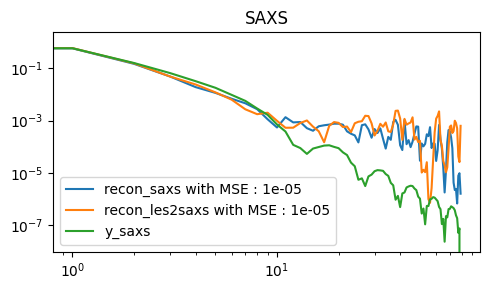

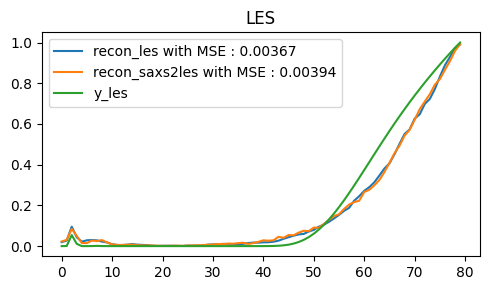

In [62]:
plot(array_train[12])

{'data_q_saxs': tensor([[0.0000, 0.0112, 0.0225, 0.0337, 0.0449, 0.0562, 0.0674, 0.0787, 0.0899,
         0.1011, 0.1124, 0.1236, 0.1348, 0.1461, 0.1573, 0.1685, 0.1798, 0.1910,
         0.2022, 0.2135, 0.2247, 0.2360, 0.2472, 0.2584, 0.2697, 0.2809, 0.2921,
         0.3034, 0.3146, 0.3258, 0.3371, 0.3483, 0.3596, 0.3708, 0.3820, 0.3933,
         0.4045, 0.4157, 0.4270, 0.4382, 0.4494, 0.4607, 0.4719, 0.4831, 0.4944,
         0.5056, 0.5169, 0.5281, 0.5393, 0.5506, 0.5618, 0.5730, 0.5843, 0.5955,
         0.6067, 0.6180, 0.6292, 0.6404, 0.6517, 0.6629, 0.6742, 0.6854, 0.6966,
         0.7079, 0.7191, 0.7303, 0.7416, 0.7528, 0.7640, 0.7753, 0.7865, 0.7978,
         0.8090, 0.8202, 0.8315, 0.8427, 0.8539, 0.8652, 0.8764, 0.8876]]), 'data_y_saxs': tensor([[1.0000e+00, 8.6565e-01, 5.6951e-01, 2.7423e-01, 9.0715e-02, 2.1618e-02,
         8.9867e-03, 6.5490e-03, 2.9093e-03, 1.4813e-03, 2.1241e-03, 1.9332e-03,
         7.5339e-04, 1.4395e-04, 2.9680e-04, 3.8953e-04, 2.3756e-04, 1.7969e-04,
  

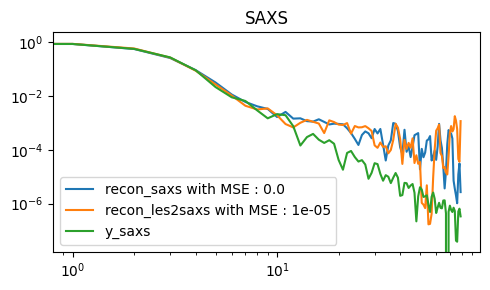

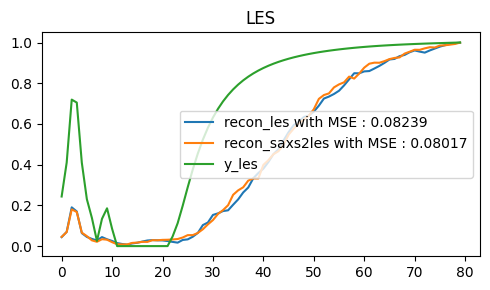

In [63]:
plot(array_train[4944])

## Valid

{'data_q_saxs': tensor([[0.0000, 0.0112, 0.0225, 0.0337, 0.0449, 0.0562, 0.0674, 0.0787, 0.0899,
         0.1011, 0.1124, 0.1236, 0.1348, 0.1461, 0.1573, 0.1685, 0.1798, 0.1910,
         0.2022, 0.2135, 0.2247, 0.2360, 0.2472, 0.2584, 0.2697, 0.2809, 0.2921,
         0.3034, 0.3146, 0.3258, 0.3371, 0.3483, 0.3596, 0.3708, 0.3820, 0.3933,
         0.4045, 0.4157, 0.4270, 0.4382, 0.4494, 0.4607, 0.4719, 0.4831, 0.4944,
         0.5056, 0.5169, 0.5281, 0.5393, 0.5506, 0.5618, 0.5730, 0.5843, 0.5955,
         0.6067, 0.6180, 0.6292, 0.6404, 0.6517, 0.6629, 0.6742, 0.6854, 0.6966,
         0.7079, 0.7191, 0.7303, 0.7416, 0.7528, 0.7640, 0.7753, 0.7865, 0.7978,
         0.8090, 0.8202, 0.8315, 0.8427, 0.8539, 0.8652, 0.8764, 0.8876]]), 'data_y_saxs': tensor([[1.0000e+00, 6.4552e-01, 1.7376e-01, 2.4718e-02, 8.1447e-03, 8.5054e-04,
         2.2309e-03, 9.2963e-04, 5.6906e-04, 1.3439e-04, 1.7604e-04, 2.0529e-04,
         9.7236e-05, 6.8476e-05, 1.3478e-05, 6.4404e-05, 3.0343e-05, 3.1218e-05,
  

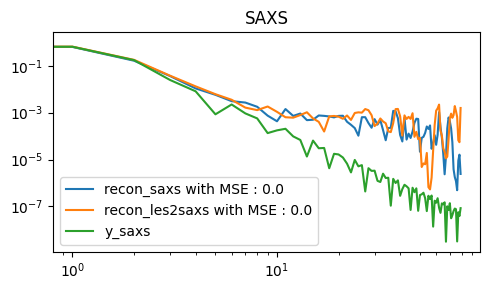

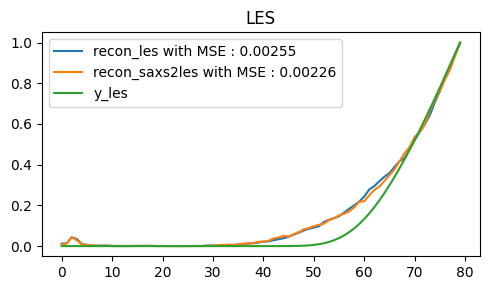

In [64]:
plot(array_valid[8224])

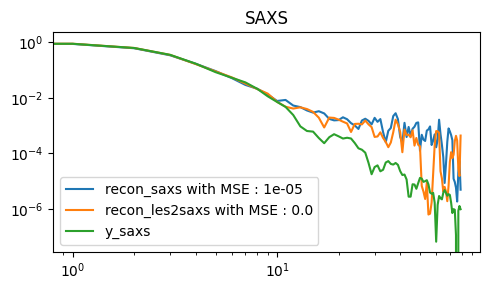

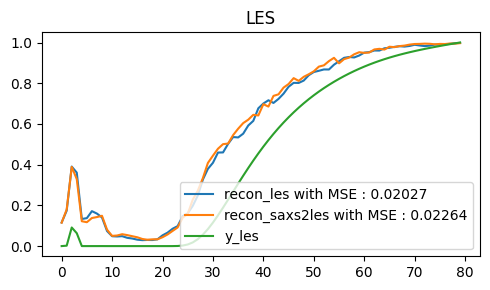

In [52]:
plot(array_valid[45])

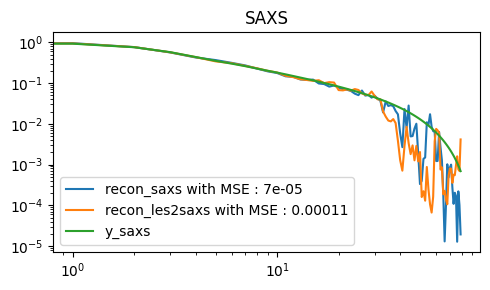

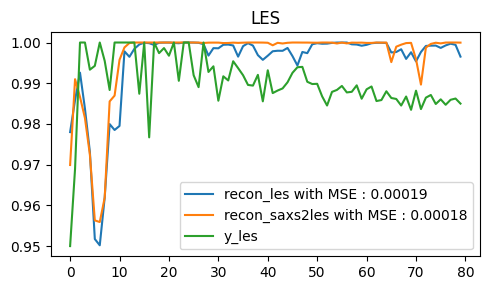

In [53]:
plot(array_valid[111])

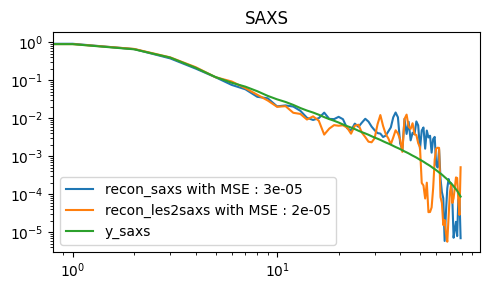

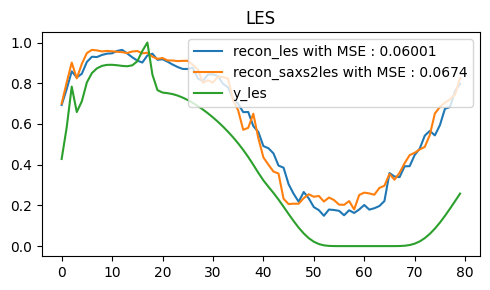

In [54]:
plot(array_valid[32])

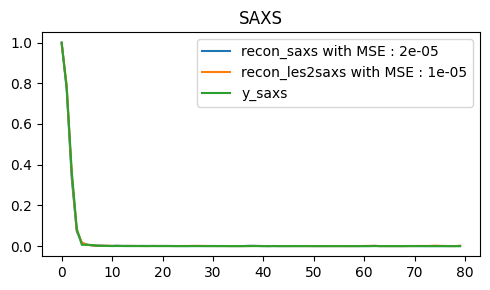

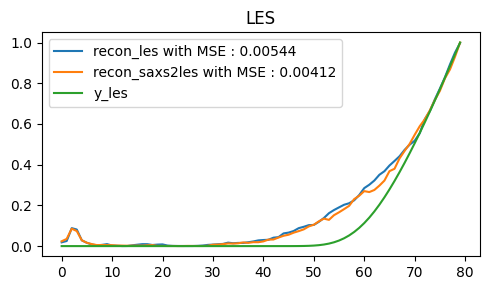

In [47]:
plot(array_valid[1215])